In [1]:
import pyfits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as skl
import sklearn.neighbors.kde as kde
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM

In [2]:
tru_hdulist = pyfits.open('Buzzard_v1.1_truth.147.fit')

In [5]:
tru_hdulist.info()

Filename: Buzzard_v1.1_truth.147.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                BinTableHDU    113   5022692R x 48C   [K, J, J, 5E, 5E, 5E, 5E, 5E, 5E, 5E, E, E, E, J, E, E, J, E, I, E, E, 2E, E, E, E, E, 5E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 2E, E, E]   


In [6]:
tru_hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  330 /Number of bytes per row                         
NAXIS2  =              5022692 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   48 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [7]:
tru_data = tru_hdulist[1].data

In [8]:
#cut the data because it's too big
n_tru = 10000
nredshifts = n_tru
tru_ind = np.random.choice(range(0,len(tru_data)),n_tru)

In [9]:
#warning, selection is slow! do this because kcorrect templates fail at high z
lo_z_ind = np.where(tru_data['Z']<2.)
#hi_z_ind = np.where(tru_data['Z']>2.)
tru_ind = np.random.choice(lo_z_ind[0],n_tru)

In [10]:
#info from the kcorrect.pro documentation:

#Outputs:

#   mass          - [ngals] model mass derived from the coeffs (current
#                   surviving stellar mass)
#   intsfh        - [ngals] total integrated star-formation history (number of
#                   stars formed total)
#   mets          - [ngals] average metallicity of currently surviving stars
#   mtol          - [nk, ngals] model mass-to-light in each *final*
#                   bandpass (the bandpass you are kcorrecting *to*)
#                   in SOLAR UNITS!
#   b300          - star-formation within last 300Myrs relative to
#                   average star-formation rate
#   b1000         - star-formation within last 1Gyrs relative to
#                   average star-formation rate




#   For v4_0b templates and later, coefficients are in units of: 
# 
#     1 solar mass / (D/10pc)^2 
#
#   That is, sum the coefficients and multiply by (D/10pc)^2 to get
#   TOTAL INTEGRATED STAR FORMATION. (In fact, for Omega0=0.3 and
#   OmegaL0=0.7, this is what the "mass" keyword returns). Note that
#   the total integrated star formation DIFFERS from the current
#   stellar mass --- which is returned in the mass and mtol variables.

In [11]:
directory=''
tspecfile=directory+'k_nmf_derived.default.fits'
t=fits.open(tspecfile)

#read in coefficients for each template
tbdata=t[18].data
tmass=t[16].data
tmremain=t[17].data
tmetallicity=t[18].data
tmass300=t[19].data
tmass1000=t[20].data

cosmology=FlatLambdaCDM(H0=70, Om0=0.286)

In [12]:
tru_coeffs = tru_data['COEFFS'][tru_ind]
coeffs = tru_coeffs.T

tru_zs = tru_data['Z'][tru_ind]
redshift = tru_zs

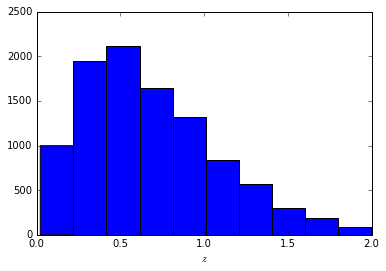

In [13]:
# warning, KDE is slow!
# X = np.random.choice(tru_data['Z'],10000)
# kde_test = kde.KernelDensity(kernel='gaussian', bandwidth=1.).fit(X.reshape(-1,1))
# X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
# res = kde_test.score_samples(X_plot)
# plt.plot(X_plot[:, 0], res)

plt.hist(tru_zs)
plt.xlabel(r'$z$')

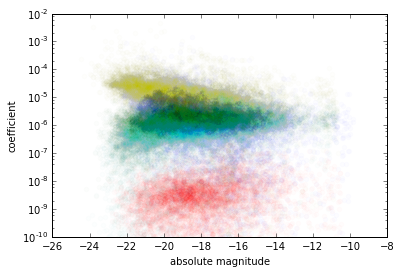

In [14]:
colors = 'brgycm'
for b in xrange(5):
    plt.scatter(tru_data['AMAG'][tru_ind][:,b],tru_coeffs[:,b],color=colors[b],alpha=0.01)
plt.semilogy()
plt.ylim(1e-10,1e-2)
plt.xlabel('absolute magnitude')
plt.ylabel('coefficient')
#print(np.shape(tru_data['COEFFS'][indices][:,0]),np.shape(tru_data['AMAG'][indices][:,0]))

In [15]:
#initialize arrays
b300=np.zeros(nredshifts)
b1000=np.zeros(nredshifts)
tmp_mass=np.zeros(nredshifts)
mets=np.zeros(nredshifts)
mass=np.zeros(nredshifts)
intsfh=np.zeros(nredshifts)

# do all the calculations, looping over objects
for i in np.arange(nredshifts):
    b300[i]=np.sum(tmass300*coeffs[:,i])/np.sum(tmass*coeffs[:,i])
    b1000[i]=np.sum(tmass1000*coeffs[:,i])/np.sum(tmass*coeffs[:,i])
    tmp_mass[i]=np.sum(tmremain*coeffs[:,i])
    mets[i]=np.sum(tmremain*tmetallicity*coeffs[:,i])/tmp_mass[i]
    dmod=cosmology.distmod(redshift[i])
    mass[i]=tmp_mass[i]*10.**(0.4*dmod.value)
    intsfh[i]=np.sum(coeffs[:,i])*10.**(0.4*dmod.value)

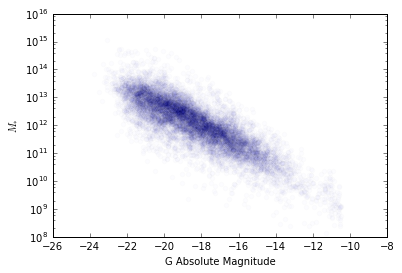

In [16]:
#stellar mass vs abs mag, seek schechter function
plt.scatter(tru_data['AMAG'][tru_ind][:,1],mass,alpha=0.01)
plt.semilogy()
plt.ylabel(r'$M_{*}$')
plt.xlabel('G Absolute Magnitude')

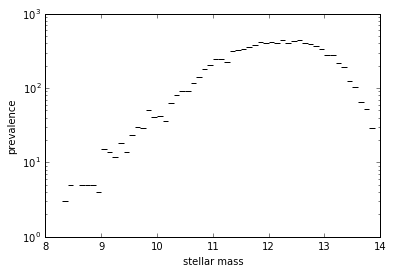

In [17]:
#seek schechter function
bins = np.arange(8,14,0.1)
plt.hist(np.log10(mass),bins=bins)
plt.semilogy()
plt.xlabel('stellar mass')
plt.ylabel('prevalence')

In [18]:
obs_hdulist = pyfits.open('Buzzard_v1.1.147.fit')

In [19]:
obs_hdulist.info()

Filename: Buzzard_v1.1.147.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                BinTableHDU     87   5022692R x 35C   [K, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In [20]:
obs_hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  144 /Number of bytes per row                         
NAXIS2  =              5022692 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   35 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [23]:
obs_data = obs_hdulist[1].data

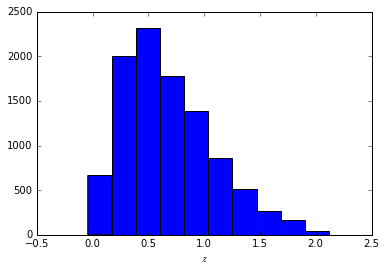

In [24]:
# warning, KDE is slow!
# X = np.random.choice(obs_data['PHOTOZ_GAUSSIAN'],10000)
# kde_test = kde.KernelDensity(kernel='gaussian', bandwidth=1.).fit(X.reshape(-1,1))
# X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
# res = kde_test.score_samples(X_plot)
# indices = np.random.choice(range(0,len(obs_data)),10000)
indices = tru_ind

plt.hist(obs_data['PHOTOZ_GAUSSIAN'][indices])
plt.xlabel(r'$z$')

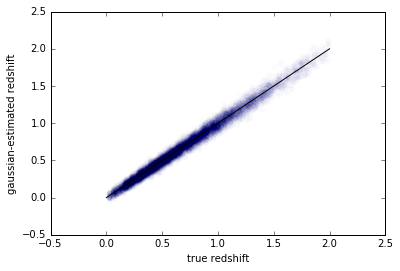

In [25]:
plt.scatter(tru_zs,obs_data['PHOTOZ_GAUSSIAN'][indices],alpha=0.01)
plt.plot([0.,2.],[0.,2.],color='k')
plt.xlabel('true redshift')
plt.ylabel('gaussian-estimated redshift')